# **Kaggle Challenge**
## The goal of the data challenge is to learn how to implement machine learning algorithms, gain understanding about them and adapt them to structural data. For this reason, we have chosen a simple classification task on graph data. There are specific rules that are described below.
## More information can be found [here](https://www.kaggle.com/competitions/data-challenge-kernel-methods-2022-2023/overview).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Go to project folder
%cd /content/drive/MyDrive/MVA/KERNEL/Projet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import

In [ ]:
import matplotlib.pylab as pl
import networkx as nx
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns

from collections import Counter
from scipy import optimize
from sklearn import metrics
from time import sleep
from tqdm import tqdm, trange

## Seed

In [ ]:
seed = 42
np.random.seed(seed)

## I. **Data Study**
### To use this cell, upload your data in a "data" folder. 

In [ ]:
# Retrieve training and test data
train_data_path = 'data/training_data.pkl'
train_labels_path = 'data/training_labels.pkl'
test_data_path = 'data/test_data.pkl'

with open(train_data_path, 'rb') as f:
  train_data = pkl.load(f)
with open(train_labels_path, 'rb') as f:
  train_labels = pkl.load(f)
with open(test_data_path, 'rb') as f:
  test_data = pkl.load(f)

## 1. Statistics on the dataset

In [ ]:
def get_statistics(graph_data):
  nb_nodes = []
  nb_edges = []
  for G in graph_data:
    nb_nodes.append(G.number_of_nodes())
    nb_edges.append(G.number_of_edges())

  return nb_nodes, nb_edges

#### Distributions of nodes and edges

In [ ]:
nb_nodes, nb_edges = get_statistics(train_data)
print('There are {} graphs in the training set'.format(len(train_data)))
print('The average number of nodes in training set is {}.'.format(round(np.mean(nb_nodes), 2)))
print('The average number of edges in training set is {}.'.format(round(np.mean(nb_edges), 2)))

There are 6000 graphs in the training set
The average number of nodes in training set is 16.14.
The average number of edges in training set is 16.26.


In [ ]:
nb_nodes, nb_edges = get_statistics(test_data)
print('There are {} graphs in the test set'.format(len(test_data)))
print('The average number of nodes in test set is {}.'.format(round(np.mean(nb_nodes), 2)))
print('The average number of edges in test set is {}.'.format(round(np.mean(nb_edges), 2)))

There are 2000 graphs in the test set
The average number of nodes in test set is 24.45.
The average number of edges in test set is 25.75.


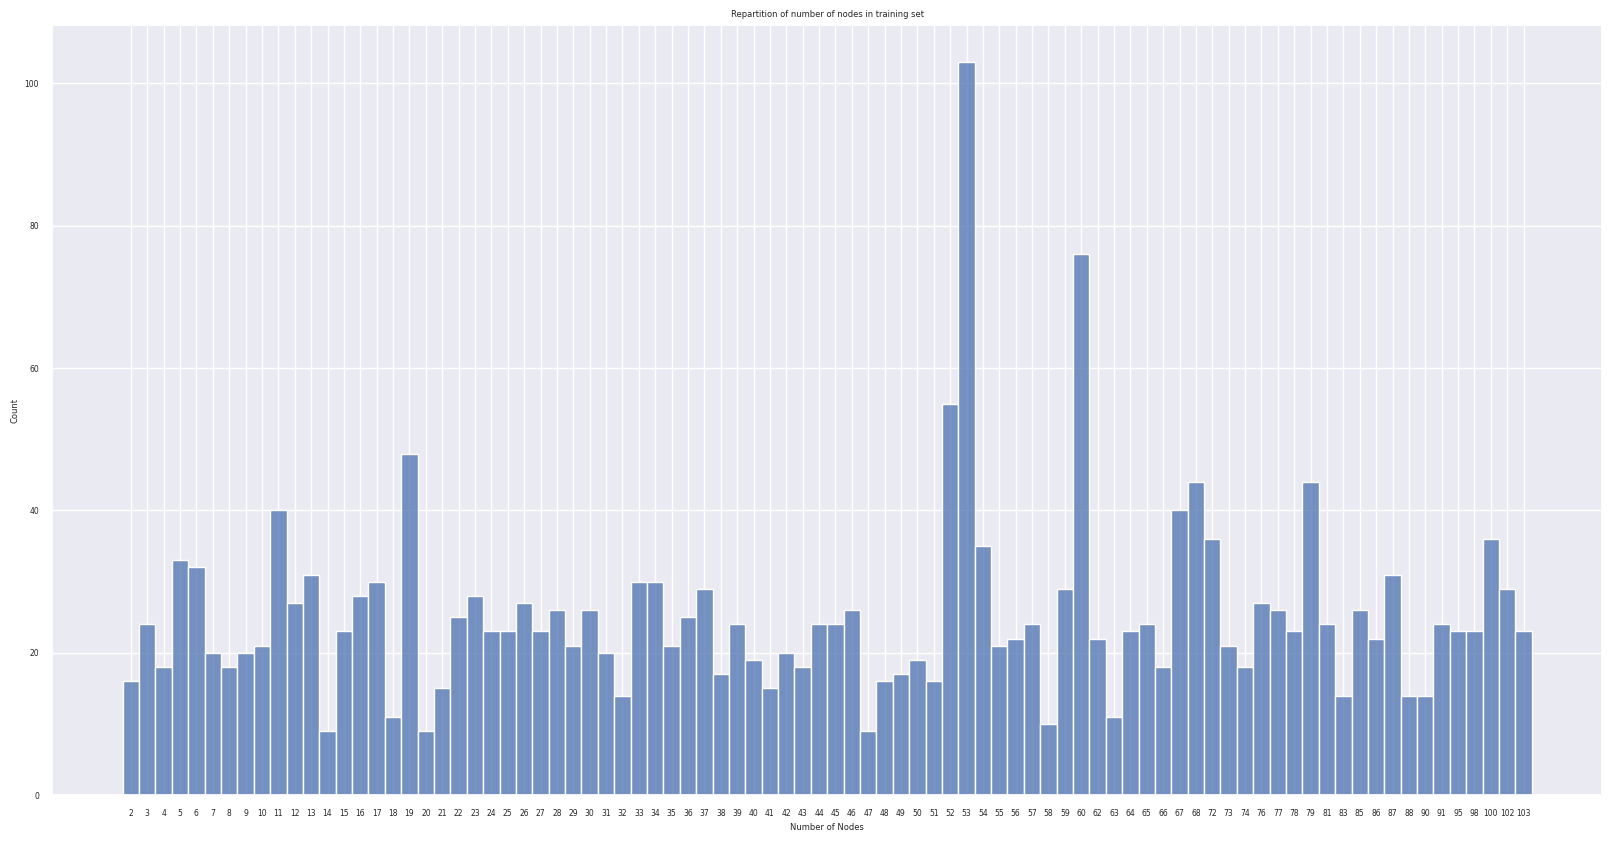

In [ ]:
figsize=(20,10)
sns.set(rc={'figure.figsize':figsize})
sns.set(font_scale=0.5)
number_of_nodes = [len(g) for g in train_data]
names_nb_nodes = [str(i) for i in np.unique(number_of_nodes)]
y = np.concatenate([occ*[name] for name, occ in zip(names_nb_nodes, number_of_nodes)])
df = pd.DataFrame(y, columns=["Number of Nodes"])
sns.histplot(data=df, x="Number of Nodes")
pl.title('Repartition of number of nodes in training set')
pl.show()

In [ ]:
count = np.zeros((len(train_data), 50), dtype=int)
for i, g in enumerate(train_data):
    c = np.bincount([g.nodes[node]['labels'][0] for node in g.nodes()])
    count[i, :len(c)]=c

node_labels_count = count.sum(axis=0) 
percentage = (node_labels_count / sum(node_labels_count)).round(3) * 100
print('Percentage of training nodes with node label: ')
for i, val in enumerate(percentage):
  if val:
    print(f'Label {i}: {round(val, 2)}%')
print('The others labels are not represented in the training set.')

Percentage of training nodes with node label: 
Label 0: 16.3%
Label 1: 71.0%
Label 2: 7.1%
Label 3: 1.0%
Label 4: 2.0%
Label 5: 1.4%
Label 6: 0.3%
Label 7: 0.1%
Label 8: 0.3%
Label 9: 0.1%
Label 13: 0.2%
The others labels are not represented in the training set.


We also have a huge imbalance between node labels. More than $70\%$ of the nodes have label $1$, whereas almost 40 labels represent less thant $10^{-3} %$ of the total node labels.

### Distributions of classes in training set

In [ ]:
def get_class_distributions(labels):
  classes = list(set(labels))
  count = {} 
  for y in labels:
    if y in count:
      count[y] += 1
    else:
      count[y] = 1
  return count

Max Class Imbalance is 1:9.81


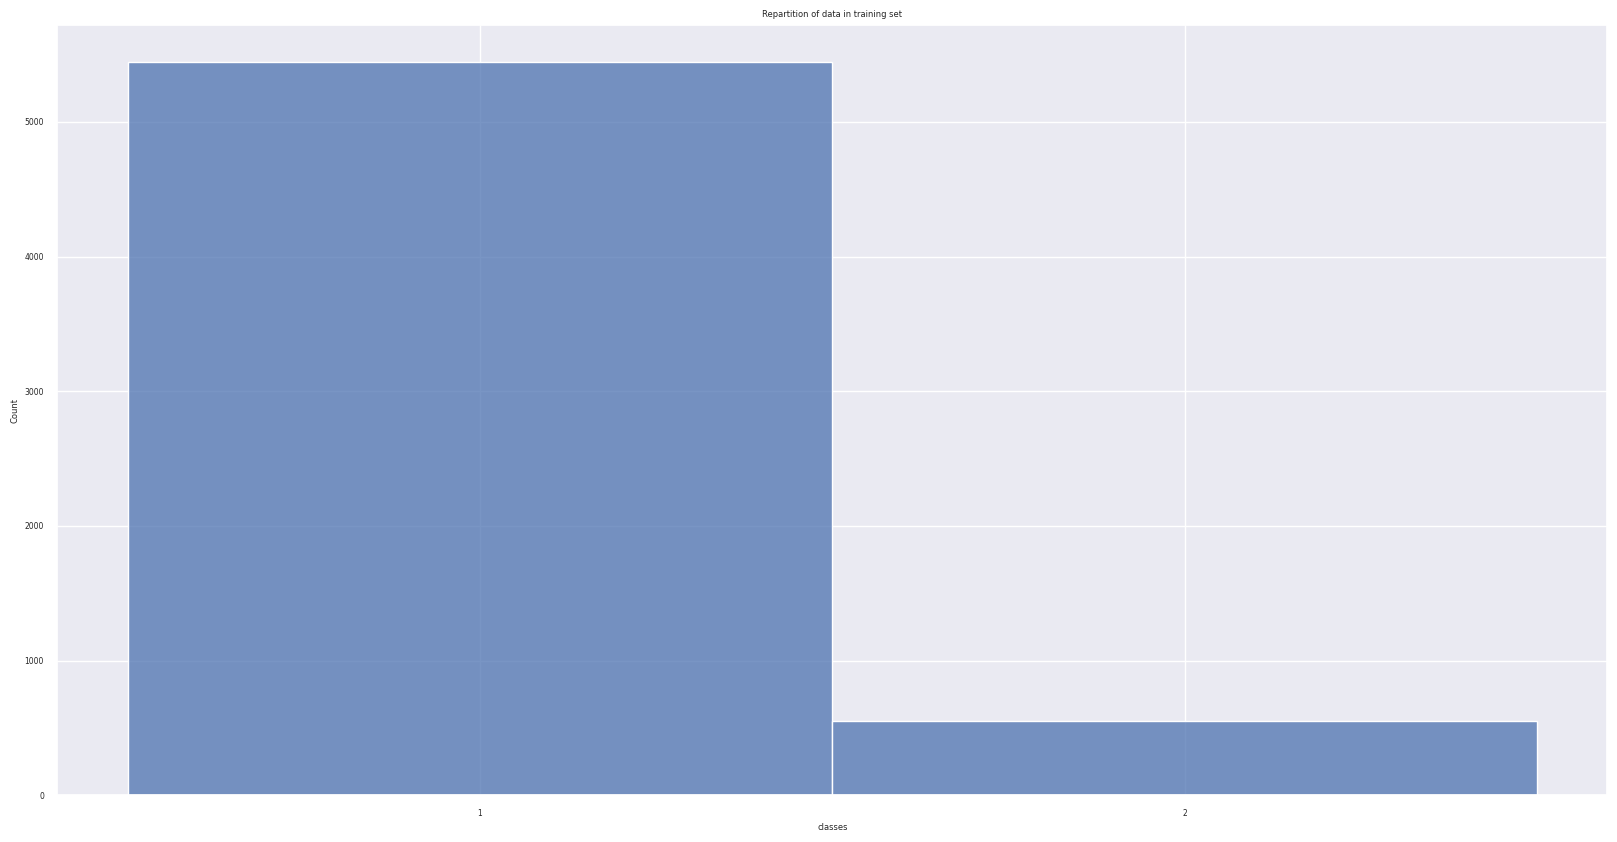

In [ ]:
occurence = list(get_class_distributions(train_labels).values())
print('Max Class Imbalance is 1:{}'.format(round(max(occurence)/min(occurence), 2)))
names = [str(i+1) for i in range(len(occurence))]
y = np.concatenate([occ*[name] for name, occ in zip(names, occurence)])
df = pd.DataFrame(y, columns=["classes"])
sns.histplot(data=df, x="classes")
pl.title('Repartition of data in training set')
pl.show()

## Analysis
#### We deal with an highly unbalanced binary classification task. The training/test split is of $75\%$ / $25\%$.

## 2. Visualization

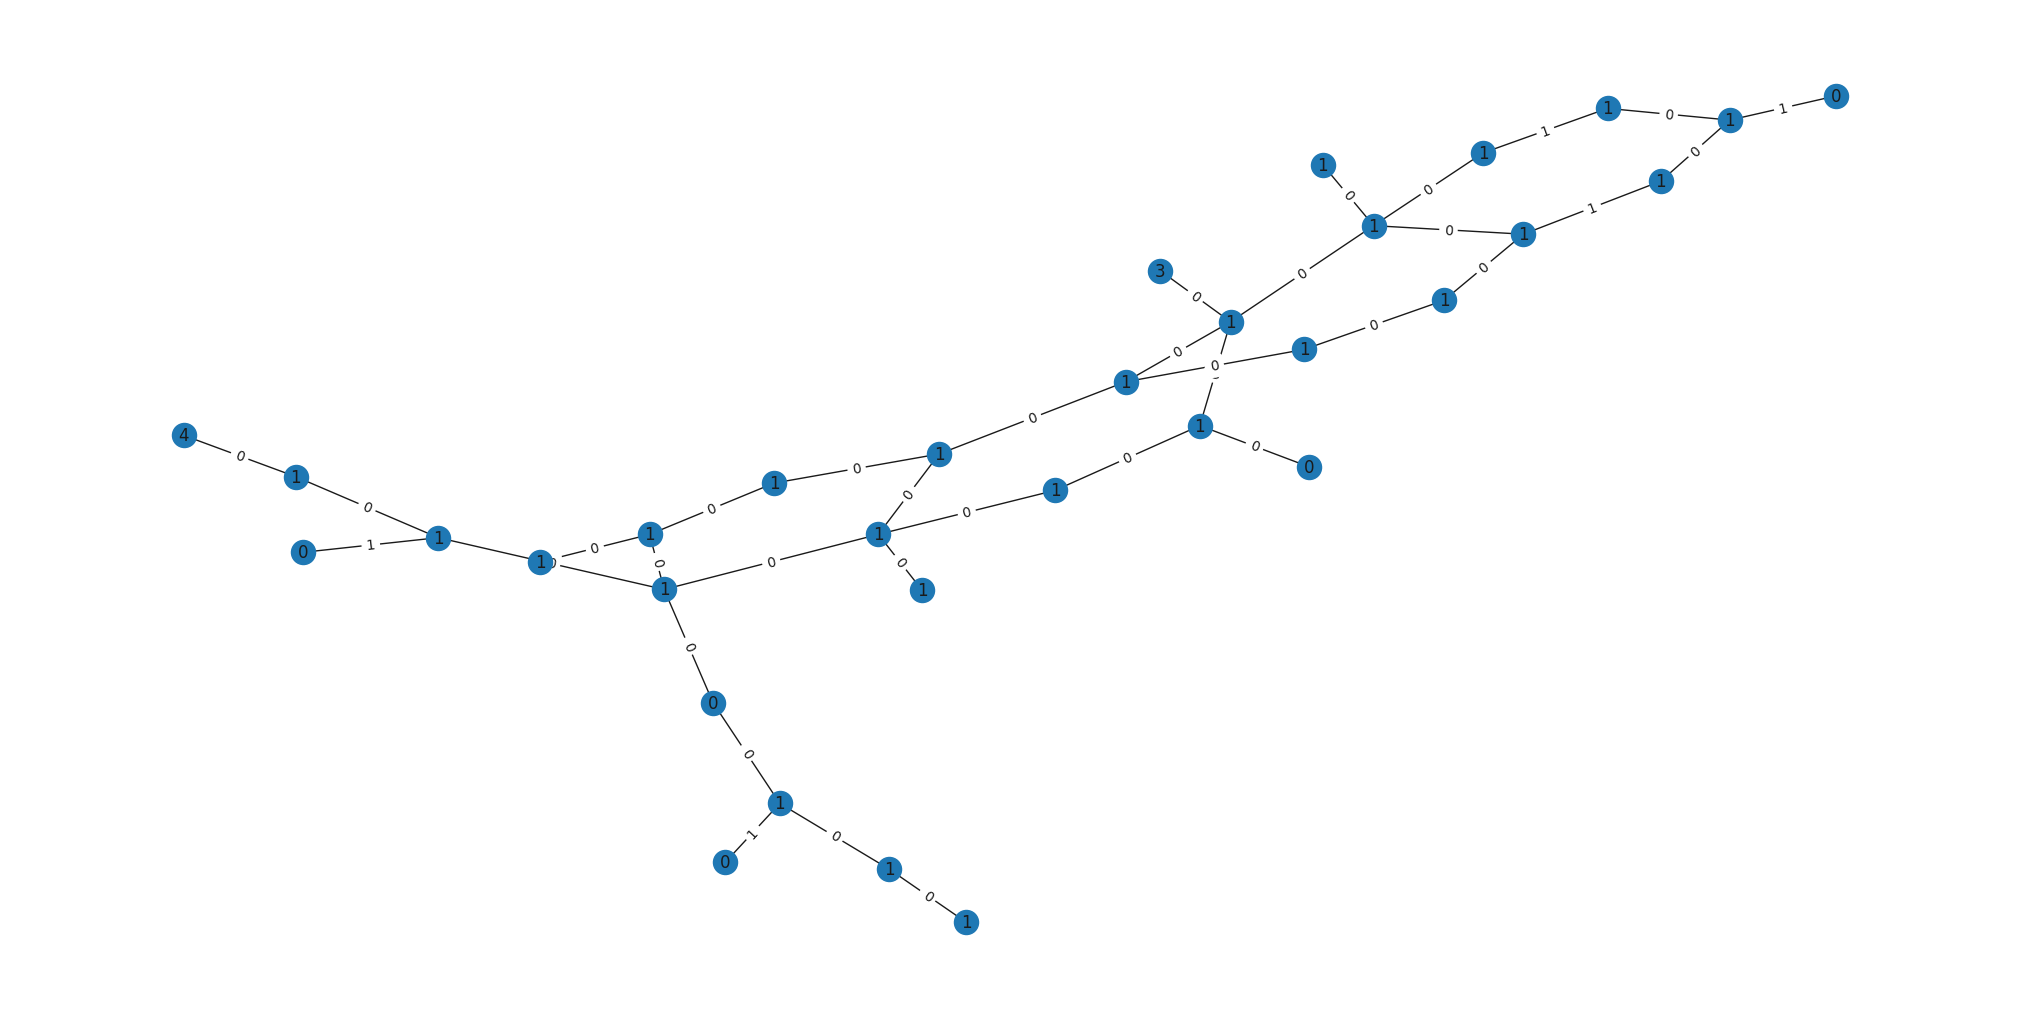

In [ ]:
# create a graph with custom node and edge labels
G = train_data[4]

nodes_labels = {node: G.nodes[node]['labels'][0] for node in G.nodes()}
edge_labels = {edge: G.edges[edge]['labels'][0] for edge in G.edges()}

# draw the graph with custom labels
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False)
nx.draw_networkx_labels(G, pos, labels=nodes_labels)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
pl.show()

###  **Training Utility Functions**
### This section contains utility functions to properly split data and recover labels in $\{-1,1\}$.

In [ ]:
# Split training/validation
def train_test_split(data, labels, train_size=0.9, random_state=42):
    """Function to split data in training and test sets."""

    np.random.seed(random_state)
    N = len(data)
    train_split = int(N * train_size)
    x_train = data[:train_split]
    y_train = labels[:train_split]
    x_test = data[train_split:]
    y_test = labels[train_split:]

    return x_train, x_test, y_train, y_test

def get_training_validation(train_data, train_labels, train_size=0.9):
    """ 
    Function to split training in training and validation.
    The label in {0,1} are transformed in labels in {-1,1}.
    We only keep training graphs that have at least one edge.
    """
    index = np.where(np.array([len(train_data[i].edges()) for i in range(len(train_data))])==0)[0]
    connected_index = set(range(len(train_data))) - set(index)
    connected_data = [train_data[i] for i in list(connected_index)]
    connected_labels = [train_labels[i] for i in list(connected_index)]

    # Transform labels
    labels = 2 * np.array(connected_labels) - 1

    # Split data
    G_train, G_val, y_train, y_val = train_test_split(connected_data,
                                                      labels,
                                                      train_size=train_size)
    return G_train, G_val, y_train, y_val

## II. **Kernels**

## Utility Functions
### This section contains utility functions to preprocess graphs and use graphs methods.

In [ ]:
"""*********Preprocessing*********"""
def preprocess_data(list_graphs, reduce_label=False):
    """
    Function to preprocess graphs. The graphs are made undirected.
    The list of graphs becomes a list of tuples (edges, node_labels, edge_labels).
    """
    G = list()
    edge_labels = None
    for g in list_graphs:
        edges = {edge for edge in dict(g.edges()).keys()}
        all_edges = {(b,a) for (a,b) in dict(g.edges()).keys()}
        all_edges.update(edges)
        node_labels = {node : g.nodes[node]['labels'][0] for node in g.nodes()}
        edge_labels = {}
        for edge in edges : 
            (a,b) = edge
            labl = g.edges[edge]['labels'][0]
            edge_labels[edge] = labl
            edge_labels[(b,a)] = labl
        if reduce_label:
            node_labels_values = list(map(lambda x : x if x in [0,1,2] else 3 , node_labels.values()))
            node_labels = dict(zip(node_labels.keys(), node_labels_values))
        G.append([all_edges, node_labels, edge_labels])
    return G

"""*********Graph Functions*********"""

# Adjacency matrix
def compute_adj(g):
    """Function to compute adjacency matrix."""
    edges, nodes, _  = g
    N = len(nodes.keys())
    adj = np.zeros((N,N))
    for (i,j) in edges:
        adj[i,j], adj[j,i] = 1, 1

    idx = adj.sum(axis=1)>0
    return adj[np.ix_(idx, idx)]

# Degree matrix
def compute_degree(W, order):
  """
  Function to compute degree matrix.

  Parameters
  ----------
  :param W : numpy array
      Adjacency matrix (n x n)
  :param order: float
      inverse if order == -1, squared root if order == -1/2
  Returns
  -------
  (n x n) dimensional matrix representing the degree matrix to the power order
  """
  
  return np.diag(W.sum(axis=1) ** order)

# Laplacian
def compute_laplacian(g, laplacian_normalization='unn'):
    """
    Function to compute graph Laplacian.

    Parameters
    ----------
    g : graph
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """   
    W = compute_adj(g)
    n = W.shape[0]
    
    # Compute laplacian
    if laplacian_normalization == 'unn':
      D = compute_degree(W, 1)
      L = D - W
    elif laplacian_normalization == 'sym':
      D_sqrt = compute_degree(W, -1/2)
      L = np.eye(n) - D_sqrt @ W @ D_sqrt
    elif laplacian_normalization == 'rw':
      D_inv = compute_degree(W, -1)
      L = np.eye(n) - D_inv @ W
    
    return L

"""*********Walk Based Kernels*********"""

# Product graph
def product_graph(g1, g2):
    """
    Function to compute the product graph between g1 and g2.
    The edges do not have labels in the product graph.
    """

    # Unpack the input graphs
    edges1, node_labels1, _ = g1
    edges2, node_labels2, _ = g2
    
    # Create the vertex set of the product graph
    vertices = [(u, v) for u in node_labels1 for v in node_labels2 if node_labels1[u] == node_labels2[v]]
    # Create the edge set of the product graph
    node_labels = {}
    for v in vertices:
        node_labels[v] = node_labels1[v[0]]

    all_nodes = list(set(node_labels.keys()))
    reindex_nodes = dict(zip(all_nodes, range(len(all_nodes))))

    node_labels = {i : node_labels[all_nodes[i]] for i in range(len(all_nodes))} 

    edges = []

    for (u1, v1) in edges1:
        for (u2, v2) in edges2:
            if (u1, u2) in vertices and (v1, v2) in vertices :
                edges.append((reindex_nodes[(u1, u2)], reindex_nodes[(v1, v2)]))
    
    # Return the product graph as a triplet of edges, node_labels, and edge_labels
    # Here we discard the edge labels
    return edges, node_labels, None

"""*********Weisfeiler-Lehman Based Kernels*********"""

def from_tuple_to_nx_graph(g_list):
    """ 
    Function to obtain a list of networkx graphs
    from a list of tuple (edges, node_labels, edge_labels).
    """
    G_list = list()
    for g in g_list:
        G = nx.Graph()
        edges, node_labels, edge_labels = g
        G.add_nodes_from(list(node_labels.keys()))
        G.add_edges_from(list(edges))
        G_list.append(G)
    return G_list

def get_neighbors(node, edges):
    neighbors = []
    for edge in edges:
        if node == edge[0]:
            neighbors.append(edge[1])
        elif node == edge[1]:
            neighbors.append(edge[0])
    neighbors = list(set(neighbors))
    return neighbors

def get_labels(edges, labels):
    node_labels={}
    for node in labels:
        neighbors = [labels[neighbor] for neighbor in get_neighbors(node, edges)]
        node_labels[node] = hash(str(labels[node]) + str(sorted(neighbors)))
    return node_labels

## 1. Random Walk Kernel

In [ ]:
def random_walk(g1, g2, lam=0.1):
    g = product_graph(g1, g2)
    adj = compute_adj(g)
    N = len(adj)
    transition_matrix =  adj / (np.repeat(adj.sum(axis=1), N).reshape(N, N))
    m = np.linalg.inv(np.eye(N) - lam*transition_matrix)
    p0 = np.ones(N)
    return p0.dot(m).dot(p0)

class RandomWalkKernel():
    def __init__(self, lam=0.1):
        self.lam = lam

    def fit_transform(self, g):
        self.g = g
        self.N = len(g)
        K = np.zeros((self.N, self.N))

        # Follow progress
        pbar = trange(self.N)
        for i in range(self.N):
            sleep(0.1)
            pbar.update(50)
            for j in range(i, self.N):
                val = random_walk(self.g[i], self.g[j], lam=self.lam)
                K[i,j], K[j,i] = val, val
        return K

    def transform(self, g_val):
        K_val  = np.zeros((len(g_val), self.N))
        for i in trange(len(g_val)):
            for j in range(self.N):
                K_val[i,j] = random_walk(g_val[i], self.g[j], lam=self.lam)
        return K_val

## 2. n-th Order Kernel

In [ ]:
def nth_order_kernel(g1, g2, n=1):
    g = product_graph(g1, g2)
    adj = compute_adj(g)
    a_n = np.linalg.matrix_power(adj, n)
    return a_n.sum()

class nthOrderKernel():
    def __init__(self, n=3):
        self.n = n

    def fit_transform(self, g):
        self.g = g
        self.N = len(g)
        K = np.zeros((self.N, self.N))

        # Follow progress
        pbar = trange(self.N)
        for i in range(self.N):
            sleep(0.1)
            pbar.update(50)
            for j in range(i, self.N):
                val = nth_order_kernel(self.g[i], self.g[j], n=self.n)
                K[i,j], K[j,i] = val, val
        return K

    def transform(self, g_val):
        K_val  = np.zeros((len(g_val), self.N))
        for i in trange(len(g_val)):
            for j in range(self.N):
                K_val[i,j] = nth_order_kernel(g_val[i], self.g[j], n=self.n)
        return K_val

### 3. Shortest Path Kernel

In [ ]:
def get_paths(g, all_paths):
    sp_counts = dict()
    N = len(g)

    # Fill all_paths on train
    for i in range(N):
        G = g[i]
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts[i]:
                        sp_counts[i][length] += 1
                    else:
                        sp_counts[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
    return sp_counts

def get_features(g, all_paths):
    N = len(g)
    sp_counts = get_paths(g, all_paths)
    phi = np.zeros((N, len(all_paths)))
    for i in range(N):
        for length in sp_counts[i]:
            phi[i, all_paths[length]] = sp_counts[i][length]
    return phi

"""
The way to call ShortestPathKernel is different from the other two because
one need to update the K_train as self.all_paths might change when it sees test data.
"""

class ShortestPathKernel():
    """
    Compute shortest path kernel
    """
    def __init__(self):
        self.all_paths = dict()

    def fit(self, g):
        self.g = g

    def fit_double_transform(self, g_val):
        # Recover networkx graphs representation
        g = from_tuple_to_nx_graph(self.g)
        g_val = from_tuple_to_nx_graph(g_val)
        N = len(g)
        sp_counts_train = get_paths(g, self.all_paths)
        sp_count_test = get_paths(g_val, self.all_paths)
        phi_train = get_features(g, self.all_paths)
        phi_test = get_features(g_val, self.all_paths)
        K = np.dot(phi_train, phi_train.T)
        K_val = np.dot(phi_test, phi_train.T)
        return K, K_val

## 2. Weisfeiler-Lehman Kernel

In [ ]:
def vertex_histogram(g1, g2):
    """ 
    Function to compute vertex histogram between two graphs.
    g1 is undirected as a list of tuples (edges, nodes_labels, edge_labels).
    """
    _, node_labels1, _ = g1
    _, node_labels2, _ = g2

    counter1 = Counter(node_labels1.values())
    counter2 = Counter(node_labels2.values())


    keys = set(counter1.keys()) | set(counter2.keys())

    phi1 = {}
    phi2 = {}
    for key in keys:
        if key not in counter1:
            counter1[key]=0
        if key not in counter2:
            counter2[key]=0

    phi1 = list({key: counter1[key] for key in sorted(counter1.keys())}.values())
    phi2 = list({key: counter2[key] for key in sorted(counter2.keys())}.values())


    return np.array(phi1, dtype='float64'), np.array(phi2, dtype='float64')

def shortest_path(g1, g2):
    g1 = [g1]
    g2 = [g2]
    g1 = from_tuple_to_nx_graph(g1)
    g2 = from_tuple_to_nx_graph(g2)
    all_paths = dict()
    sp_counts_g1 = get_paths(g1, all_paths)
    sp_counts_g2 = get_paths(g2, all_paths)
    phi1 = get_features(g1, all_paths)
    phi2 = get_features(g2, all_paths)

    return phi1.flatten(), phi2.flatten()

def weisfeiler_lehman(g1, g2, kernel=vertex_histogram, n_iter=10, normalize=True):
    edges1, labels1, _  = g1
    edges2, labels2, _  = g2

    phi1, phi2 = kernel(g1, g2)    
    new_g1_labels = labels1
    new_g2_labels = labels2

    for i in range(n_iter):
        new_g1_labels = get_labels(edges1, new_g1_labels)
        new_g2_labels = get_labels(edges2, new_g2_labels)

        all_news_labels = set(new_g1_labels.values()).union(set(new_g2_labels.values()))
        reindex_dict = dict(zip(all_news_labels, range(len(all_news_labels))))

        new_g1_labels = {node : reindex_dict[new_g1_labels[node]] for node in new_g1_labels}
        new_g2_labels = {node : reindex_dict[new_g2_labels[node]] for node in new_g2_labels}


        new_g1 = edges1, new_g1_labels, _ 
        new_g2 = edges2, new_g2_labels, _ 

        phi1_new, phi2_new = kernel(new_g1, new_g2)
        phi1 = np.concatenate([phi1, phi1_new])
        phi2 = np.concatenate([phi2, phi2_new])

    if normalize:
        phi1/= np.linalg.norm(phi1)
        phi2/= np.linalg.norm(phi2)
    
    return phi1.dot(phi2)

class WeisfeilerLehmanKernel():
    def __init__(self, kernel=vertex_histogram, n_iter=5, normalize=True):
        self.kernel = kernel
        self.n_iter = n_iter
        self.normalize = normalize

    def fit_transform(self, g):
        self.g = g
        self.N = len(g)
        K = np.ones((self.N, self.N))

        # Follow progress
        for i in trange(self.N):
            for j in range(i+1, self.N):
                val = weisfeiler_lehman(self.g[i],
                                        self.g[j],
                                        kernel=self.kernel,
                                        n_iter=self.n_iter,
                                        normalize=self.normalize)
                K[i,j], K[j,i] = val, val
        return K

    def transform(self, g_val):
        K_val  = np.zeros((len(g_val), self.N))
        for i in trange(len(g_val)):
            for j in range(self.N):
                K_val[i,j] = weisfeiler_lehman(g_val[i],
                                               self.g[j],
                                               kernel=self.kernel,
                                               n_iter=self.n_iter,
                                               normalize=self.normalize)
        return K_val

## III. Classifier

### 1. Support Vector Classifier
### This is a very efficient implementation of a SVM based on splitting the optimization problem in several small problems. Inspired from [this blog](https://emilemathieu.fr/posts/2018/08/svm/).

In [ ]:
class FastKernelSVM():
    def __init__(self, C=1000, max_iter=1000, tol=1e-3):
        self.C = C # penalty coefficient
        self.max_iter = max_iter # maximum number of iterations for solver
        self.tol = tol # tolerance for the solver

    def _compute_weights(self, K, y):
        iteration = 0
        n_samples, _ = K.shape
        alpha = np.zeros(n_samples) # Initialise coefficients to 0  w
        g = np.ones(n_samples) # Initialise gradients to 1

        while True:
            yg = g * y

            # Working Set Selection via maximum violating constraints
            indices_y_positive = (y == 1)
            indices_y_negative = (np.ones(n_samples) - indices_y_positive).astype(bool) #(y == -1)
            indices_alpha_upper = (alpha >= self.C)
            indices_alpha_lower = (alpha <= 0)

            indices_violate_Bi = (indices_y_positive * indices_alpha_upper) + (indices_y_negative * indices_alpha_lower)
            yg_i = yg.copy()
            yg_i[indices_violate_Bi] = float('-inf') #cannot select violating indices
            indices_violate_Ai = (indices_y_positive * indices_alpha_lower) + (indices_y_negative * indices_alpha_upper)
            yg_j = yg.copy()
            yg_j[indices_violate_Ai] = float('+inf') #cannot select violating indices

            i = np.argmax(yg_i)
            j = np.argmin(yg_j)

            # Stopping criterion: stationary point or maximum iterations
            stop_criterion = yg_i[i] - yg_j[j] < self.tol
            if stop_criterion or (iteration >= self.max_iter and self.max_iter != -1):
                break

            # Compute lambda via Newton Method and constraints projection
            lambda_max_1 = (y[i] == 1) * self.C - y[i] * alpha[i]
            lambda_max_2 = y[j] * alpha[j] + (y[j] == -1) * self.C
            lambda_max = np.min([lambda_max_1, lambda_max_2])

            Ki = K[i,:] 
            Kj = K[j,:]
            lambda_plus = (yg_i[i] - yg_j[j]) / (Ki[i] + Kj[j] - 2 * Ki[j])
            lambda_param = np.max([0, np.min([lambda_max, lambda_plus])])

            # Update gradient
            g = g + lambda_param * y * (Kj - Ki)

            # Direction search update
            alpha[i] = alpha[i] + y[i] * lambda_param
            alpha[j] = alpha[j] - y[j] * lambda_param

            iteration += 1

        # Compute intercept
        intercept = self._compute_intercept(alpha, yg)

        return alpha, intercept

    def _compute_intercept(self, alpha, yg):
        indices = (alpha < self.C) * (alpha > 0)
        return np.mean(yg[indices])

    def fit(self, K, y):
        # Compute coefficients of the dual problem
        lagrange_multipliers, intercept = self._compute_weights(K, y)
        self.alpha = lagrange_multipliers
        self.intercept_ = intercept # b
        self.support_vector_indices = lagrange_multipliers > self.tol
        self.dual_coef_ = lagrange_multipliers[self.support_vector_indices] * y[self.support_vector_indices] # alpha_i * y_i

    def predict(self, K_test, sign=True):
        # Given a new datapoint, predict its label
        kernel_support_vectors = K_test[:, self.support_vector_indices] 
        prediction = self.intercept_ + np.sum(np.multiply(kernel_support_vectors, self.dual_coef_),1)
        if sign : 
            return np.sign(prediction)
        else : 
            return prediction

    def score(self, K_test, y_test, sign=True):
        # Compute proportion of correct classifications given true labels
        y_pred = self.predict(K_test)
        if sign:
            y_pred = np.sign(y_pred)
        score = np.equal(y_pred, y_test)
        return  score.sum() / y_pred.shape[0]
    
    def AUC(self, K_test, y_test, sign=True):
        # Compute proportion of correct classifications given true labels
        y_pred = self.predict(K_test)
        if sign:
            y_pred = np.sign(y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        return  auc

### Kernel Logistic Regression

In [ ]:
class LogisticRegression():

    def __init__(self, kernel=None, lmbda=1, max_iter=500, eps=1e-5, precomputed=True):
        self.kernel = kernel
        self.max_iter = max_iter
        self.lmbda = lmbda
        self.eps = eps
        self.precomputed = precomputed

    def fit(self, X, y):
        self.N = len(y)
        self.X = X
        if not self.precomputed:
            self.K = self.kernel(X,X)
        else : 
            self.K = X
        self.y = y

        def solveWKRR(K, W, z, lmbda):
            Ws = np.sqrt(W)
            b = Ws.dot(z)
            A = Ws.dot(K).dot(Ws) + lmbda * self.N * np.eye(self.N)
            alpha = Ws.dot(np.linalg.solve(A, b))
            return alpha
        
        sigmoid = lambda u : 1/(1+np.exp(-u))
        
        alpha = np.random.rand(self.N)
        for _ in trange(self.max_iter):
            m = self.K.dot(alpha)
            pt = -sigmoid(-y*m)
            wt = sigmoid(m)*sigmoid(-m)

            zt = m + y/(sigmoid(y*m)+self.eps)

            W = np.diag(wt)
            
            alpha = solveWKRR(self.K, W, zt, self.lmbda)

        self.alpha = alpha

    def predict(self, x, sign=True):
        if not self.precomputed:
            K_star = self.kernel(x, self.X)
        else :
            K_star = x
        m_star = K_star.dot(self.alpha)
        if sign :
            return np.sign(m_star)
        else : 
            return m_star

    def score(self, x, y_test, sign=True):
        if not self.precomputed:
            K_star = self.kernel(x, self.X)
        else :
            K_star = x
        m_star = K_star.dot(self.alpha)
        if sign:
            m_star = np.sign(m_star)
        score = np.equal(m_star, y_test)
        return  score.sum() / m_star.shape[0]
    
    def AUC(self, x, y_test, sign=True):
        if not self.precomputed:
            K_star = self.kernel(x, self.X)
        else :
            K_star = x
        m_star = K_star.dot(self.alpha)
        if sign:
            m_star = np.sign(m_star)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, m_star, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        return  auc

### Multiple Kernel Learning
### MKL implementation inspired from [this notebook](https://github.com/LouisBouvier/KM_challenge/blob/master/kernel_models.py).

In [ ]:
def simplex_projection(eta):
    """
    See https://lcondat.github.io/publis/Condat_simplexproj.pdf,
    Algorithm 1 for an explanation of this function
    """
    u = np.sort(eta)[::-1]
    tmp = (np.cumsum(u) - 1) / (np.arange(len(eta)) + 1)
    nonzero = np.nonzero(tmp < u)[0]
    if len(nonzero) > 0:
        K = nonzero[-1]
    else:
        K = -1
    tau = tmp[K]
    return np.maximum(eta - tau, 0)


class MKLKernel(object):

    def __init__(self, kernels, step, n_iterations=1, C=1.0, max_iter=1000, tol=0.001):
        """
        inputs:
            - C: penalisation parameter for the SVM
            - max_iter: max iteration in the SVM
            - tol: tolerance for support vectors in SVM
            - kernels: dict of list of kernels to use for training and testing. This datastructure should have the following format:
                        - "train"
                        | -- (array) kernel 1
                        | -- (array) kernel 2
                        | -- ...
                        - "eval"
                        | -- (array) kernel 1
                        | -- (array) kernel 2
                        | -- ...
            - step: gradient descent step
            - n_iterations: number of iterations for the projected gradient algorithm.
        """
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.kernels = kernels
        self.step = step
        self.n_iterations = n_iterations

        assert len(kernels["train"]) == len(kernels["eval"])
        self.n_kernels = len(kernels["train"])
        self.eta = np.ones(self.n_kernels) / self.n_kernels

    def fit(self, y):

        for _ in range(self.n_iterations):
            # compute weighted sum of kernels
            K_tr = sum([self.eta[i] * self.kernels["train"][i] for i in range(self.n_kernels)])

            # compute your objective function by fitting a SVM
            model = FastKernelSVM(C=self.C, max_iter=self.max_iter, tol=self.tol)
            model.fit(K_tr, y)
            self.alpha = model.alpha
            # gradient descent step
            grad = np.zeros(self.n_kernels)
            for i in range(self.n_kernels):
                K_tr_i = self.kernels["train"][i]
                grad[i] = - self.C * self.alpha.T @ K_tr_i @ self.alpha
            self.eta -= self.step * grad

            # projection of the new eta to the simplex
            self.eta = simplex_projection(self.eta)

        # fit your model with your final parameters. We also load the evaluation kernel so that we can run directly functions from the SVM class
        K = sum([self.eta[i] * self.kernels["train"][i] for i in range(self.n_kernels)])
        self.model = FastKernelSVM(C=self.C, max_iter=self.max_iter, tol=self.tol)
        self.model.fit(K, y)

    def predict(self, sign=True):
        """
        inputs:
        - K_test (size N_test x N_train): test kernel matrix
        output:
         - the predicted class for the associated y given the
        Linear Regression parameters
        """
        K_test = sum([self.eta[i] * self.kernels["eval"][i] for i in range(self.n_kernels)])
        return self.model.predict(K_test, sign=sign)

    def score(self, y_test, sign=True):
        """
        inputs:
        - X (size N_texd): the points in R^d we want to classify
        - y (size N_tex1): the labels of the points
        """
        K_test = sum([self.eta[i] * self.kernels["eval"][i] for i in range(self.n_kernels)])
        return self.model.score(K_test, y_test, sign=sign)

    def AUC(self, y_test, sign=True):
        """
        inputs:
        - X (size N_texd): the points in R^d we want to classify
        - y (size N_tex1): the labels of the points
        """
        K_test = sum([self.eta[i] * self.kernels["eval"][i] for i in range(self.n_kernels)])
        return self.model.AUC(K_test, y_test, sign=sign)

## IV. Training

In [ ]:
class KernelClassifier():
    def __init__(self,
                 graph_kernel=WeisfeilerLehmanKernel(),
                 clf=FastKernelSVM(C=1000, max_iter=1000),
                 n_data=500,
                 n_model=11,
                 MKL_kernels=[WeisfeilerLehmanKernel(), nthOrderKernel(n=3)],
                 params={'step': 5, 'n_iterations': 1, 'C': 1.0, 'max_iter': 1000, 'tol': 0.001},
                 sign=False,
                 exception=False,
                 voting=False,
                 use_median=False):
        self.gk = graph_kernel
        self.clf = clf
        self.n_data = n_data
        self.n_model = n_model
        self.MKL_kernels = MKL_kernels
        self.params = params
        self.sign = sign
        self.exception = exception
        self.voting = voting
        self.use_median = use_median

    def train(self, train_data, train_labels, train_size=0.9):
        """Function to split data and train models."""

        # Split training, validation and transform labels in {-1,1}
        G_train, G_val, y_train, y_val = get_training_validation(train_data,
                                                                train_labels,
                                                                train_size=train_size)
        
        # Preprocess data to have undirected graphs
        g_train = preprocess_data(G_train)
        g_val = preprocess_data(G_val)

        # Split positive and negative examples
        g_neg = [g_train[i] for i in  np.where(y_train==-1)[0]]
        g_pos = [g_train[i] for i in  np.where(y_train==1)[0]]

        # Training models and get predictions
        self.models = list()
        self.train_preds = list()
        for i in trange(self.n_model):
            idx_moins = np.random.choice(len(g_neg), self.n_data // 2, replace=False)
            idx_plus = np.random.choice(len(g_pos), self.n_data // 2, replace=False)
            g_tr = [g_neg[i] for i in idx_moins] + [g_pos[i] for i in idx_plus] 
            labels = np.concatenate([-1 * np.ones(self.n_data // 2), np.ones(self.n_data // 2)])

            if self.MKL_kernels:
                MKL_dict = {'train':[], 'eval':[]}
                for kernel in self.MKL_kernels:
                    K_train = kernel.fit_transform(g_tr)
                    K_val = kernel.transform(g_val)
                    MKL_dict['train'].append(K_train)
                    MKL_dict['eval'].append(K_val)
                self.mkl = MKLKernel(MKL_dict, **self.params)
                self.mkl.fit(labels)
                y_pred = self.mkl.predict(sign=self.sign)
                score = self.mkl.score(y_val)
                auc_score = self.mkl.AUC(y_val)
                print(f' Validation Accuracy: {score:.3f}, Validation AUC: {auc_score:.3f}')

                # Update models and predictions
                self.models.append(self.mkl)
                self.train_preds.append(y_pred)
            else:
                # If kernel is the ShortestPathKernel
                if self.exception:
                    self.gk.fit(g_tr)
                    K_train, K_val = self.gk.fit_double_transform(g_val)
                else:
                    K_train = self.gk.fit_transform(g_tr)
                    K_val = self.gk.transform(g_val)

                # Train and predict
                self.clf.fit(K_train, labels)
                y_pred = self.clf.predict(K_val, sign=self.sign)
                score = self.clf.score(K_val, y_val)
                auc_score = self.clf.AUC(K_val, y_val)
                print(f' Validation Accuracy: {score:.3f}, Validation AUC: {auc_score:.3f}')

                # Update models and predictions
                self.models.append((self.clf, self.gk))
                self.train_preds.append(y_pred)
        self.train_preds = np.array(self.train_preds)

    def predict(self, test_data):
        g_test = preprocess_data(test_data)
        preds = list()            
        if self.MKL_kernels:
            for mkl in self.models:
                for i, kernel in enumerate(self.MKL_kernels):
                    K_test = kernel.transform(g_test)
                    mkl.kernels['eval'][i] = K_test
                y_pred = mkl.predict(sign=self.sign)
                preds.append(y_pred)
        else:
            for clf, gk in self.models:
                if self.exception:
                    _, K_test = gk.fit_double_transform(g_test)
                else:
                    K_test = gk.transform(g_test)
                y_pred = clf.predict(K_test, sign=self.sign)
                preds.append(y_pred)
        preds = np.array(preds)
        if self.voting:
            signs = np.sign(preds).sum(axis=0)
            return np.sign(signs)
        if self.use_median :
            return np.median(preds, axis=0)
        else:
            return np.mean(preds, axis=0)

## **Results**
### Run the next cell to reproduce our best result on the public Kaggle Challenge.
### It takes approximatively 13 hours to run.


In [ ]:
graph_kernel = WeisfeilerLehmanKernel(n_iter=5,
                                      kernel=vertex_histogram,
                                      normalize=True) 
exception = False
clf = FastKernelSVM(C=1000, max_iter=1000)
n_model = 10
n_data = 500
train_size = 0.9
MKL_kernels = [] #[nthOrderKernel(n=2), nthOrderKernel(n=3)]
sign = False
use_median = False
kernel_clf = KernelClassifier(graph_kernel=graph_kernel,
                              clf=clf,
                              n_model=n_model,
                              n_data=n_data,
                              MKL_kernels=MKL_kernels,
                              sign=sign,
                              exception=exception,
                              use_median=use_median)
kernel_clf.train(train_data, train_labels, train_size=train_size)
preds_test = kernel_clf.predict(test_data)

100%|██████████| 500/500 [04:58<00:00,  1.67it/s]

100%|██████████| 600/600 [10:30<00:00,  1.05s/it]
<ipython-input-22-3103cce45ac1>:44: RuntimeWarning: divide by zero encountered in double_scalars
  lambda_plus = (yg_i[i] - yg_j[j]) / (Ki[i] + Kj[j] - 2 * Ki[j])
 10%|█         | 1/10 [15:29<2:19:22, 929.18s/it]

 Validation Accuracy: 0.798, Validation AUC: 0.775



100%|██████████| 500/500 [05:21<00:00,  1.56it/s]

 20%|██        | 2/10 [31:56<2:08:25, 963.22s/it]

 Validation Accuracy: 0.817, Validation AUC: 0.825



100%|██████████| 500/500 [05:14<00:00,  1.59it/s]

 30%|███       | 3/10 [48:05<1:52:41, 965.95s/it]

 Validation Accuracy: 0.837, Validation AUC: 0.835



100%|██████████| 500/500 [05:27<00:00,  1.52it/s]

 40%|████      | 4/10 [1:05:11<1:38:57, 989.53s/it]

 Validation Accuracy: 0.837, Validation AUC: 0.753



100%|██████████| 500/500 [05:18<00:00,  1.57it/s]

 50%|█████     | 5/10 [1:21:19<1:21:50, 982.01s/it]

 Validation Accuracy: 0.850, Validation AUC: 0.760



100%|██████████| 500/500 [05:15<00:00,  1.59it/s]

 60%|██████    | 6/10 [1:37:29<1:05:11, 977.76s/it]

 Validation Accuracy: 0.790, Validation AUC: 0.730



100%|██████████| 500/500 [05:20<00:00,  1.56it/s]

 70%|███████   | 7/10 [1:53:32<48:39, 973.01s/it]  

 Validation Accuracy: 0.845, Validation AUC: 0.798



100%|██████████| 500/500 [05:01<00:00,  1.66it/s]

 80%|████████  | 8/10 [2:09:06<32:01, 960.65s/it]

 Validation Accuracy: 0.782, Validation AUC: 0.766



100%|██████████| 500/500 [05:22<00:00,  1.55it/s]

 90%|█████████ | 9/10 [2:25:39<16:10, 970.74s/it]

 Validation Accuracy: 0.788, Validation AUC: 0.810



100%|██████████| 500/500 [05:08<00:00,  1.62it/s]

100%|██████████| 10/10 [2:41:42<00:00, 970.20s/it]


 Validation Accuracy: 0.805, Validation AUC: 0.696


 12%|█▏        | 232/2000 [07:26<53:23,  1.81s/it]

In [ ]:
preds_test

array([ 68.40633675,  98.28282744, 246.29899865, ...,  29.36323043,
        12.89992279,  90.87433801])

## Evaluation

In [ ]:
def get_csv_preds(preds_test, filename):
    # Upload prediction in csv format
    Yte = {'Predicted' : preds_test} 
    dataframe = pd.DataFrame(Yte) 
    dataframe.index += 1 
    path_str = filename + '.csv'
    dataframe.to_csv(path_str, index_label='Id') 
    return

In [ ]:
get_csv_preds(preds_test, 'test_WL_kernel_50_10')